In [1]:
# https://androidkt.com/use-saved-pytorch-model-to-predict-single-and-multiple-images/
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-predict-new-samples-with-your-pytorch-model.mdS
# https://towardsdatascience.com/optimize-pytorch-performance-for-speed-and-memory-efficiency-2022-84f453916ea6
# https://www.kaggle.com/code/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99#3.-RNN-with-1-Layer-%F0%9F%93%98
# https://www.kaggle.com/code/omershect/learning-pytorch-lstm-deep-learning-with-m5-data/comments
# https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from pickle import load

2023-03-09 21:05:45.741765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 21:05:45.824527: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-09 21:05:45.827447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-03-09 21:05:45.827459:

In [2]:
def to_sequence(data, timesteps=1):
    n_features=data.shape[2]
    x = []
    y = []
    for i in range(len(data)-timesteps):
        # takes a window of data of specified timesteps
        
        _x = data[i:(i+timesteps)]
        _x = _x.reshape(timesteps, n_features)
#         print(_x.shape)
        _y = data[i+timesteps]
        _y = _y.reshape(n_features)
#         print(_y.shape)
        x.append(_x)
        y.append(_y)

        
    return np.array(x), np.array(y)

In [3]:
def seriest_to_supervised(data, n_in=1, n_out=1):
    """
    n_in: number of observations used to forecast future
    n_out: number of time steps predicted in the future
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     # forecast sequence (t,t+1, ....t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

In [4]:
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(data[i+look_back,0])
    
    return np.array(dataX), np.array(dataY)



In [5]:
def to_nooverlap_sequence(data, timesteps=1):
    x = []
    for i in np.arange(0,len(data)-1,timesteps):
        _x = data[i:i+timesteps]
        x.append(_x)
        
    return np.array(x)

In [6]:
# df = pd.read_csv('./robotdatacollection3_part2/200_episodes_robot.csv')
df = pd.read_csv('./robotdatacollection_testing_50/ep10.csv')
model_path = './GoogleColab/Lstm_newModel_2'
feature_list = ['Fx','Fy','Fz','Mx','My']
TIMESTEP = 50

In [61]:
df[feature_list].describe()

,Fx,Fy,Fz,Mx,My
count,5375.000000,5375.000000,5375.000000,5375.000000,5375.000000
mean,-0.550008,-0.019625,5.007472,0.022035,-0.000717
std,1.042399,1.177445,0.940778,0.119826,0.128783
min,-3.457502,-4.713465,1.141933,-0.473518,-0.273028
25%,-1.467780,-1.000491,4.589540,-0.085931,-0.118890
50%,-0.487434,0.222045,4.986279,0.040444,-0.007145
75%,0.381589,1.014787,5.401231,0.129683,0.118584
max,1.631099,1.999143,10.130983,0.214143,0.355007


In [62]:
df = df[feature_list]
print('Shape before adding dimension:',df.shape)

Shape before adding dimension: (5375, 5)


In [63]:
# scaler = load(open('./GoogleColab/Normalizing.pkl', 'rb'))

In [64]:
window = 10
df_new = df
df_new = df.rolling(window).mean()
df_new = df_new[window-1:]

# scaler = MinMaxScaler(feature_range=(-1, 1))
# fit scaler to the train data
# scaler = scaler.fit(df_new)
# scale train data
# names = df_new.columns
# df_new[names] = scaler.transform(df_new[names])
df_new_tf = df_new
df_new = np.expand_dims(df_new, axis=1)
print('Shape AFTER adding dimension:',df_new.shape)

x_train, y_train = to_sequence(df_new, timesteps=TIMESTEP)
print(f"""x_train = {x_train.shape}, 
y_train = {y_train.shape}""")

Shape AFTER adding dimension: (5366, 1, 5)
x_train = (5316, 50, 5), 
y_train = (5316, 5)


### LSTM


LSTM layers work on 3D data with the following structure `(sequence/batch, timestep, feature)`.

* **input_dim**: Number of samples in the data. In our case we do not use batches but instead one sample at a time. Each sample has TIMESTEP size of data in it. 
* **hidden_dim**: Number of LSTM cells
* **layer_dim**: Number of LSTM hidden layers
* **output_dim**: Number of outputs = feature number (in case of regression task)




* `return_sequences=False`: outputs 2D array containing only the output of the last time step
* `return_sequences=True`: outputs 3D array containing all the time steps


In [39]:
def repeat(x_inp):
    x, inp = x_inp
    x = tf.expand_dims(x,1)
    x = tf.repeat(x, [tf.shape(inp)[1]],axis=1)
    return x


In [40]:

n_features = x_train.shape[2]

input_layer = keras.layers.Input(shape=(None, n_features))

lstm1 = keras.layers.LSTM(units=50, activation='tanh', name='LSTM_1', return_sequences=False)(input_layer)
dropout1 = keras.layers.Dropout(0.2)(lstm1)

code = keras.layers.Lambda(repeat)([dropout1, input_layer])

lstm2 = keras.layers.LSTM(units=50, activation='tanh', name='LSTM_2', return_sequences=True)(code)


dropout2 = keras.layers.Dropout(0.2)(lstm2)
out = keras.layers.TimeDistributed(keras.layers.Dense(units=n_features))(dropout2)

model = keras.Model(input_layer, outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")


* `batch_size`: N-different measurements, each contains sequence of length L
* `sequence_length`: L: length of each time series sequence
* `input_size`: Hin: number of features
* `hidden_dim`: number of units in LSTM layer
* `output_dim`: output size/ how many predictions at a time

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 LSTM_1 (LSTM)                  (None, 50)           11200       ['input_2[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 50)           0           ['LSTM_1[0][0]']                 
                                                                                                  
 lambda_2 (Lambda)              (None, None, 50)     0           ['dropout_4[0][0]',              
                                                                  'input_2[0][0]']          

In [42]:
x_train.shape

(5325, 50, 5)

In [43]:
# we train autoencoder, so both train data and labels are equal to x_train
# define early stopping to prevent overfit
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                               patience=15, 
                                               mode="min", 
                                               verbose=1,
                                               restore_best_weights=True)
history = model.fit(x_train, x_train,
            epochs=200,
            batch_size=64,
            validation_split=0.1,
            callbacks=[early_stopping],
            verbose=True)

Epoch 1/200
75/75 [==============================] - 4s 33ms/step - loss: 1.1073 - val_loss: 0.5279
Epoch 2/200
75/75 [==============================] - 2s 22ms/step - loss: 0.4275 - val_loss: 0.4314
Epoch 3/200
75/75 [==============================] - 2s 23ms/step - loss: 0.3630 - val_loss: 0.4058
Epoch 4/200
75/75 [==============================] - 2s 23ms/step - loss: 0.3304 - val_loss: 0.3989
Epoch 5/200
75/75 [==============================] - 2s 26ms/step - loss: 0.3110 - val_loss: 0.3994
Epoch 6/200
75/75 [==============================] - 2s 23ms/step - loss: 0.2981 - val_loss: 0.3944
Epoch 7/200
75/75 [==============================] - 2s 22ms/step - loss: 0.2878 - val_loss: 0.3846
Epoch 8/200
75/75 [==============================] - 2s 22ms/step - loss: 0.2795 - val_loss: 0.3776
Epoch 9/200
75/75 [==============================] - 2s 21ms/step - loss: 0.2702 - val_loss: 0.3731
Epoch 10/200
75/75 [==============================] - 2s 21ms/step - loss: 0.2646 - val_loss: 0.3686

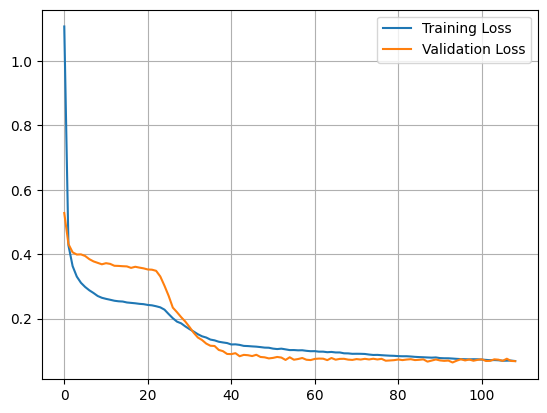

In [44]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid()
plt.legend()
plt.show()

In [65]:
model = keras.models.load_model(model_path)

In [66]:
x_train_pred = model.predict(x_train)

167/167 [==============================] - 2s 6ms/step


In [67]:
x_train_pred.shape

(5316, 50, 5)

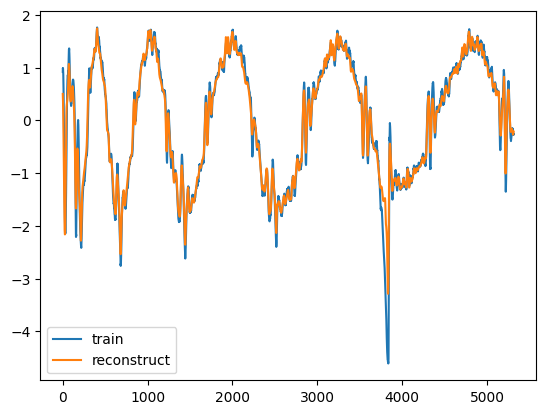

In [68]:
plt.plot(x_train[:,1,1],label='train')
plt.plot(x_train_pred[:,1,1],label='reconstruct')
plt.legend()

In [69]:
n_features = x_train.shape[2]
predict_batch_size = 1

input_layer = keras.layers.Input(batch_shape=(predict_batch_size, None, n_features), name='Encoder_Input')

lstm1 = keras.layers.LSTM(units=50, activation='tanh', name='LSTM_1', return_sequences=False, stateful=True)(input_layer)
dropout1 = keras.layers.Dropout(0.2)(lstm1)

code = keras.layers.Lambda(repeat)([dropout1, input_layer])

lstm2 = keras.layers.LSTM(units=50, activation='tanh', name='LSTM_2', return_sequences=True, stateful=True)(code)

dropout2 = keras.layers.Dropout(0.2)(lstm2)
out = keras.layers.TimeDistributed(keras.layers.Dense(units=n_features))(dropout2)

predict_model = keras.Model(input_layer, outputs=out)
predict_model.set_weights(model.get_weights())

In [70]:
# model.get_weights()
model.layers[1].states

ListWrapper([None, None])

In [71]:
# predict_model.get_weights()
predict_model.layers[1].states

ListWrapper([<tf.Variable 'LSTM_1/Variable:0' shape=(1, 50) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>, <tf.Variable 'LSTM_1/Variable:0' shape=(1, 50) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>])

In [72]:
fx = df_new_tf.Fx.values
fy = df_new_tf.Fy.values
fz = df_new_tf.Fz.values
mx = df_new_tf.Mx.values
my = df_new_tf.My.values

In [73]:
duration = len(fx)
print(duration)


5366


In [74]:
len(fx)

5366

In [75]:
stateful = True

cnt = 0
t_start=0
statefull_pred = np.empty((0, 1, 5))

while cnt < 5000: 
    features = [fx[cnt], fy[cnt], fz[cnt], mx[cnt],my[cnt]]
#     features_df = pd.DataFrame([features], columns=feature_list)
#     scaled_features = scaler.transform(features_df)

    x_test_single = np.reshape(features, (1, 1, 5))
    x_test_pred_stateful = predict_model.predict_on_batch(x_test_single)
    # append for plotting
    statefull_pred = np.concatenate((statefull_pred, x_test_pred_stateful), axis=0)


    cnt += 1

In [76]:
stateful = False

cnt = 0
stateless_pred = np.empty((0, 1, 5))

while cnt < 5000: 
    features = [fx[cnt], fy[cnt], fz[cnt], mx[cnt],my[cnt]]
#     features_df = pd.DataFrame([features], columns=feature_list)
#     scaled_features = scaler.transform(features_df)

    x_test_single = np.reshape(features, (1, 1, 5))
    x_test_pred_stateless = model.predict_on_batch(x_test_single)
    # append for plotting
    stateless_pred = np.concatenate((stateless_pred, x_test_pred_stateless), axis=0)
    
    cnt += 1

In [77]:
# statefull
statefull_pred.shape

(5000, 1, 5)

In [78]:
#stateless
stateless_pred.shape

(5000, 1, 5)

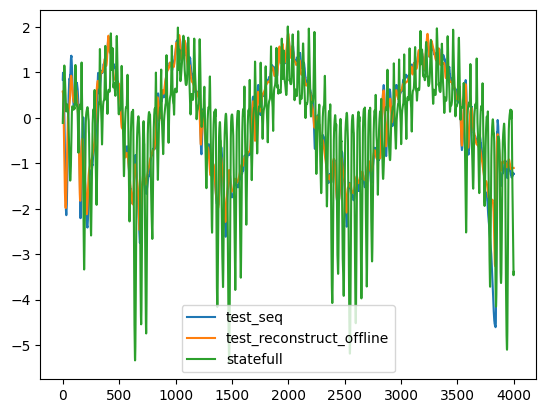

In [79]:
end = 4000
feat = 1
plt.plot(x_train[:end,0,feat],label='test_seq')
plt.plot(x_train_pred[:end,0,feat],label='test_reconstruct_offline')
# plt.plot(stateless_pred[:end,:,feat],label='stateless')
plt.plot(statefull_pred[:end,:,feat], label='statefull')
plt.legend()
plt.show()

### Compare

In [32]:
end = 5000

plt.plot(np.array(x_test_single_preds_list_stateless)[:,1][:end],label='stateless')
plt.plot(df.Fy.loc[0:end],label='real')
plt.plot(np.array(x_test_single_preds_list_stateful)[:,1][:end],label='stateful')
plt.legend()
plt.show()

NameError: name 'x_test_single_preds_list_stateless' is not defined

## Test set

In [ ]:
df_test_original = pd.read_csv('/content/drive/MyDrive/train_data_part1/ep2.csv')

In [ ]:
dt = 1/125
time_sec = 4
index_cut = int(time_sec/dt)
print(index_cut)
# verify that we cut appropiately to 4 sec of data from start
print(df_test_original.t.iloc[index_cut]-df_test_original.t.iloc[0])
# cut the first X sec
df_test_original = df_test_original.drop(range(index_cut)).reset_index(drop=True)


one_occurace = np.where(df_test_original.Case == 1)[0]
print(one_occurace)

In [ ]:
df_test = df_test_original[feature_list]
print(df_test.shape)

In [ ]:
df_test = df_test.rolling(window).mean()
df_test = df_test[window-1:]
df_test = scaler.transform(df_test)
print(df_test.shape)

In [ ]:
df_test = np.expand_dims(df_test, axis=1)

In [ ]:
print(df_test.shape)

In [ ]:
df_test_seq, _ = to_sequence(df_test, timesteps=TIMESTEP)

In [ ]:
df_test_seq.shape

In [ ]:
x_pred_test = model.predict(df_test_seq)

In [ ]:
plt.plot(df_test_seq[:,1,1],label='train')
plt.plot(x_pred_test[:,1,1],label='reconstruct')
plt.legend()

In [ ]:
n_features = x_train.shape[2]
predict_batch_size = 1

input_layer = keras.layers.Input(batch_shape=(predict_batch_size, None, n_features), name='Encoder_Input')

lstm1 = keras.layers.LSTM(units=50, activation='tanh', name='LSTM_1', return_sequences=False, stateful=True)(input_layer)
dropout1 = keras.layers.Dropout(0.2)(lstm1)

code = keras.layers.Lambda(repeat)([dropout1, input_layer])

lstm2 = keras.layers.LSTM(units=50, activation='tanh', name='LSTM_2', return_sequences=True, stateful=True)(code)

dropout2 = keras.layers.Dropout(0.2)(lstm2)
out = keras.layers.TimeDistributed(keras.layers.Dense(units=n_features))(dropout2)

predict_model_test = keras.Model(input_layer, outputs=out)
predict_model_test.set_weights(model.get_weights())

In [ ]:
stateful = True

cnt = 0
t_start=0
x_test_single_preds_list_stateful = []

while cnt < 5000: 
    features = [fx[cnt], fy[cnt], fz[cnt], mx[cnt],my[cnt]]
    features_df = pd.DataFrame([features], columns=feature_list)
    scaled_features = scaler.transform(features_df)

    x_test_single = np.reshape(scaled_features, (1, 1, 5))
    
    x_test_pred_single = predict_model_test.predict_on_batch(x_test_single)
    x_test_single_preds_list_stateful.append(x_test_pred_single.flatten())

    cnt += 1

#### real-time predictions

In [ ]:
n_features = x_train.shape[2]
predict_batch_size = 1

# encoder
input_layer = keras.layers.Input(batch_shape=(predict_batch_size, None, n_features), name='Encoder_Input')

conv1 = keras.layers.Conv1D(filters=32, kernel_size=15, padding='same', 
                            data_format='channels_last',dilation_rate=1, 
                            activation="linear", name='Encoder_Conv')(input_layer)

lstm1 = keras.layers.LSTM(units=50, activation='tanh', name='Encoder_LSTM', 
                          return_sequences=False, stateful=True)(conv1)

dropout1 = keras.layers.Dropout(0.2, name='Encoder_Dropout')(lstm1)

code = keras.layers.Lambda(repeat)([dropout1, input_layer])

# decoder
lstm2 = keras.layers.LSTM(units=50, activation='tanh', name='Decoder_LSTM', 
                          return_sequences=True, stateful=True)(code)

conv2 = keras.layers.Conv1D(filters=32, kernel_size=15, padding='same', 
                            data_format='channels_last',dilation_rate=1, 
                            activation="linear",name='Decoder_Conv')(lstm2)

dropout2 = keras.layers.Dropout(0.2, name='Decoder_Dropout')(conv2)
out = keras.layers.TimeDistributed(keras.layers.Dense(units=n_features), name='Output_Layer')(dropout2)


predict_model = keras.Model(input_layer, outputs=out)
predict_model.set_weights(train_model.get_weights())

In [ ]:
test_feature = np.ones((1,1,2))
print(test_feature.shape)

In [ ]:
cnt = 0
while cnt < 50:
    
    t_start = time.time()
    y = predict_model(test_feature)
    print('dt', time.time()-t_start)
    print(y)
    
    
    cnt += 1

In [ ]:
x_train.shape

In [ ]:
# lstm_model = LSTMModel(x_train)
# model = LSTM_autoencoder(x_train)

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
# history = model.fit(x_train, x_train,
#             epochs=10,
#             batch_size=32,
#             verbose=True)

# history = lstm_model.fit(x_train, y_train,
#             epochs=10,
#             batch_size=64,
#             verbose=True)

In [ ]:
# model.summary()

In [ ]:
# model = keras.models.load_model('Lstm_200data_withConv_5features_50lstm_Nonelayer')
# thresholds = [0.6840775931796239,
#  0.619880549677451,
#  0.6973050180917997,
#  0.08286759972221247,
#  0.12042164920931024]

In [ ]:
feature_list

In [ ]:
x_test = np.ones((1,1,1))
print(x_test.shape)
y_pred = model(x_test)
print(y_pred.shape)
print(y_pred)

In [ ]:
x_test = np.ones((1,50,1))
print(x_test.shape)
y_pred = model(x_test)
print(y_pred.shape)
print(y_pred)

## TEST

In [ ]:
t = 0
times_dnn = []
x_test = np.ones((1,1,5))

while t < 2:
    t_start = time.time()
    
#     y_pred = lstm_model(x_test)
    y_pred = model(x_test)
    print(y_pred.shape)
    dt = time.time()-t_start
    print(dt)
    
    times_dnn.append(dt)
    t += 1

In [ ]:
print(x_test.shape)
print(y_pred.shape)
print(y_test.shape)

In [ ]:
a = np.ones((1,50,2))
print(a.shape)

In [ ]:
lstm_model.predict(a)

In [ ]:
b = np.ones((1,1,2))
print(b.shape)

In [ ]:
lstm_model.predict(b)

In [ ]:
t_pred = np.arange(0,len(y_test))

plt.figure(figsize=(15,10))
plt.plot(t_pred, y_pred[:,0],label='pred')
plt.plot(t_pred, y_test[:,0],label='test', alpha=0.7)
plt.legend()
plt.grid()
plt.show()

In [ ]:
t_pred = np.arange(0,len(y_test))

plt.figure(figsize=(15,10))
plt.plot(t_pred, y_pred[:,1],label='pred')
plt.plot(t_pred, y_test[:,1],label='test', alpha=0.7)
plt.legend()
plt.grid()
plt.show()